In [16]:
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [17]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("nyc-taxi-experiment")

<Experiment: artifact_location='file:///c:/Users/walea/OneDrive/Desktop/MLOps_zoomcamp/02-Exp-tracking/mlruns/1', creation_time=1716746134559, experiment_id='1', last_update_time=1716746134559, lifecycle_stage='active', name='nyc-taxi-experiment', tags={}>

In [18]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [19]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.060351540140314

C:\Users\walea\AppData\Local\Temp\ipykernel_11652\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\walea\AppData\Local\Temp\ipykernel_11652\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


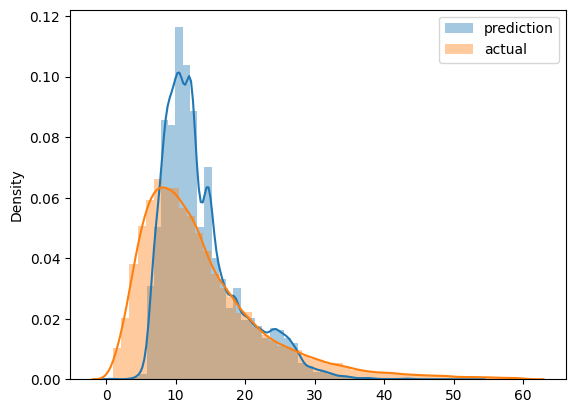

In [20]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [21]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [22]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet')
len(df_train), len(df_val)

(65946, 62574)

In [23]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [24]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


6.03727552054262

In [25]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [26]:
with mlflow.start_run():
    
    mlflow.set_tag("developer", "olawale")
    
    mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
    mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
    
    alpha = 0.01
    mlflow.log_param("alpha", alpha)
    lr = Lasso(alpha)
    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
import xgboost as xgb

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [28]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [29]:
def objective(params):
    
    with mlflow.start_run():
        
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

In [30]:
search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 4, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -3, 0), # exp(-3), exp(0) - [0.05, 1]
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'objective': 'reg:linear',
    'seed': 42
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=Trials()
)

  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:00:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.21876                           
[1]	validation-rmse:6.20617                           
[2]	validation-rmse:5.75308                           
[3]	validation-rmse:5.55064                           
[4]	validation-rmse:5.45001                           
[5]	validation-rmse:5.39415                           
[6]	validation-rmse:5.37234                           
[7]	validation-rmse:5.34975                           
[8]	validation-rmse:5.34127                           
[9]	validation-rmse:5.33572                           
[10]	validation-rmse:5.33296                          
[11]	validation-rmse:5.32974                          
[12]	validation-rmse:5.32278                          
[13]	validation-rmse:5.31878                          
[14]	validation-rmse:5.31485                          
[15]	validation-rmse:5.31168                          
[16]	validation-rmse:5.30841                          
[17]	validation-rmse:5.30439                          
[18]	valid

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:01:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.03300                                                    
[1]	validation-rmse:5.48778                                                    
[2]	validation-rmse:5.37997                                                    
[3]	validation-rmse:5.34058                                                    
[4]	validation-rmse:5.33168                                                    
[5]	validation-rmse:5.31521                                                    
[6]	validation-rmse:5.30836                                                    
[7]	validation-rmse:5.29848                                                    
[8]	validation-rmse:5.29658                                                    
[9]	validation-rmse:5.29197                                                    
[10]	validation-rmse:5.28523                                                   
[11]	validation-rmse:5.28490                                                   
[12]	validation-rmse:5.28015            

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:02:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.30074                                                    
[1]	validation-rmse:7.51603                                                    
[2]	validation-rmse:6.92403                                                    
[3]	validation-rmse:6.47827                                                    
[4]	validation-rmse:6.15612                                                    
[5]	validation-rmse:5.91972                                                    
[6]	validation-rmse:5.73945                                                    
[7]	validation-rmse:5.60454                                                    
[8]	validation-rmse:5.51116                                                    
[9]	validation-rmse:5.44717                                                    
[10]	validation-rmse:5.40099                                                   
[11]	validation-rmse:5.35618                                                   
[12]	validation-rmse:5.33021            

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:04:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.65765                                                      
[1]	validation-rmse:5.43899                                                      
[2]	validation-rmse:5.41341                                                      
[3]	validation-rmse:5.39901                                                      
[4]	validation-rmse:5.39119                                                      
[5]	validation-rmse:5.38286                                                      
[6]	validation-rmse:5.37779                                                      
[7]	validation-rmse:5.36462                                                      
[8]	validation-rmse:5.35914                                                      
[9]	validation-rmse:5.35303                                                      
[10]	validation-rmse:5.35088                                                     
[11]	validation-rmse:5.34477                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.33266                                                    
[1]	validation-rmse:5.61877                                                    
[2]	validation-rmse:5.44236                                                    
[3]	validation-rmse:5.38271                                                    
[4]	validation-rmse:5.36455                                                    
[5]	validation-rmse:5.35926                                                    
[6]	validation-rmse:5.35502                                                    
[7]	validation-rmse:5.35396                                                    
[8]	validation-rmse:5.35143                                                    
[9]	validation-rmse:5.34313                                                    
[10]	validation-rmse:5.34099                                                   
[11]	validation-rmse:5.33895                                                   
[12]	validation-rmse:5.33514            

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:05:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.64148                                                    
[1]	validation-rmse:8.06778                                                    
[2]	validation-rmse:7.58765                                                    
[3]	validation-rmse:7.18750                                                    
[4]	validation-rmse:6.85785                                                    
[5]	validation-rmse:6.58504                                                    
[6]	validation-rmse:6.36069                                                    
[7]	validation-rmse:6.17838                                                    
[8]	validation-rmse:6.02895                                                    
[9]	validation-rmse:5.90707                                                    
[10]	validation-rmse:5.80894                                                   
[11]	validation-rmse:5.72913                                                   
[12]	validation-rmse:5.66336            

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:07:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.14804                                                    
[1]	validation-rmse:6.07301                                                    
[2]	validation-rmse:5.57768                                                    
[3]	validation-rmse:5.35712                                                    
[4]	validation-rmse:5.26068                                                    
[5]	validation-rmse:5.21770                                                    
[6]	validation-rmse:5.19820                                                    
[7]	validation-rmse:5.18281                                                    
[8]	validation-rmse:5.17748                                                    
[9]	validation-rmse:5.17362                                                    
[10]	validation-rmse:5.16907                                                   
[11]	validation-rmse:5.16076                                                   
[12]	validation-rmse:5.16039            

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:08:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.58945                                                    
[1]	validation-rmse:7.97500                                                    
[2]	validation-rmse:7.46002                                                    
[3]	validation-rmse:7.03265                                                    
[4]	validation-rmse:6.68143                                                    
[5]	validation-rmse:6.39306                                                    
[6]	validation-rmse:6.15873                                                    
[7]	validation-rmse:5.96818                                                    
[8]	validation-rmse:5.81465                                                    
[9]	validation-rmse:5.69161                                                    
[10]	validation-rmse:5.59256                                                   
[11]	validation-rmse:5.51330                                                   
[12]	validation-rmse:5.44968            

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:10:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.13158                                                      
[1]	validation-rmse:7.25518                                                      
[2]	validation-rmse:6.62481                                                      
[3]	validation-rmse:6.18041                                                      
[4]	validation-rmse:5.87429                                                      
[5]	validation-rmse:5.66471                                                      
[6]	validation-rmse:5.52181                                                      
[7]	validation-rmse:5.42515                                                      
[8]	validation-rmse:5.35878                                                      
[9]	validation-rmse:5.31151                                                      
[10]	validation-rmse:5.27829                                                     
[11]	validation-rmse:5.25676                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:13:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.56381                                                       
[1]	validation-rmse:5.47616                                                       
[2]	validation-rmse:5.45987                                                       
[3]	validation-rmse:5.45175                                                       
[4]	validation-rmse:5.44201                                                       
[5]	validation-rmse:5.42963                                                       
[6]	validation-rmse:5.42125                                                       
[7]	validation-rmse:5.41763                                                       
[8]	validation-rmse:5.39712                                                       
[9]	validation-rmse:5.39394                                                       
[10]	validation-rmse:5.38744                                                      
[11]	validation-rmse:5.38300                                                      
[12]

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:13:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.19288                                                     
[1]	validation-rmse:6.17982                                                     
[2]	validation-rmse:5.73899                                                     
[3]	validation-rmse:5.53711                                                     
[4]	validation-rmse:5.44364                                                     
[5]	validation-rmse:5.39587                                                     
[6]	validation-rmse:5.37746                                                     
[7]	validation-rmse:5.36941                                                     
[8]	validation-rmse:5.35712                                                     
[9]	validation-rmse:5.35416                                                     
[10]	validation-rmse:5.35378                                                    
[11]	validation-rmse:5.34979                                                    
[12]	validation-rmse:5.34942

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:14:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.34263                                                     
[1]	validation-rmse:5.47569                                                     
[2]	validation-rmse:5.26204                                                     
[3]	validation-rmse:5.20654                                                     
[4]	validation-rmse:5.19087                                                     
[5]	validation-rmse:5.18441                                                     
[6]	validation-rmse:5.18062                                                     
[7]	validation-rmse:5.18111                                                     
[8]	validation-rmse:5.17747                                                     
[9]	validation-rmse:5.17607                                                     
[10]	validation-rmse:5.17606                                                    
[11]	validation-rmse:5.17630                                                    
[12]	validation-rmse:5.17356

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:15:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.35483                                                     
[1]	validation-rmse:6.33027                                                     
[2]	validation-rmse:5.82702                                                     
[3]	validation-rmse:5.58301                                                     
[4]	validation-rmse:5.46993                                                     
[5]	validation-rmse:5.40636                                                     
[6]	validation-rmse:5.37194                                                     
[7]	validation-rmse:5.34870                                                     
[8]	validation-rmse:5.33271                                                     
[9]	validation-rmse:5.32343                                                     
[10]	validation-rmse:5.31196                                                    
[11]	validation-rmse:5.30693                                                    
[12]	validation-rmse:5.29700

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:16:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.81662                                                     
[1]	validation-rmse:8.36535                                                     
[2]	validation-rmse:7.96287                                                     
[3]	validation-rmse:7.60694                                                     
[4]	validation-rmse:7.29145                                                     
[5]	validation-rmse:7.01292                                                     
[6]	validation-rmse:6.76873                                                     
[7]	validation-rmse:6.55362                                                     
[8]	validation-rmse:6.36701                                                     
[9]	validation-rmse:6.20331                                                     
[10]	validation-rmse:6.06217                                                    
[11]	validation-rmse:5.93903                                                    
[12]	validation-rmse:5.83398

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:19:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.53253                                                     
[1]	validation-rmse:5.42133                                                     
[2]	validation-rmse:5.39527                                                     
[3]	validation-rmse:5.37793                                                     
[4]	validation-rmse:5.35892                                                     
[5]	validation-rmse:5.35040                                                     
[6]	validation-rmse:5.33664                                                     
[7]	validation-rmse:5.33058                                                     
[8]	validation-rmse:5.32300                                                     
[9]	validation-rmse:5.30947                                                     
[10]	validation-rmse:5.30732                                                    
[11]	validation-rmse:5.30385                                                    
[12]	validation-rmse:5.29844

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:19:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.09156                                                     
[1]	validation-rmse:5.48746                                                     
[2]	validation-rmse:5.39491                                                     
[3]	validation-rmse:5.36637                                                     
[4]	validation-rmse:5.36349                                                     
[5]	validation-rmse:5.35572                                                     
[6]	validation-rmse:5.34905                                                     
[7]	validation-rmse:5.34559                                                     
[8]	validation-rmse:5.35020                                                     
[9]	validation-rmse:5.34563                                                     
[10]	validation-rmse:5.34502                                                    
[11]	validation-rmse:5.34304                                                    
[12]	validation-rmse:5.34318

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:21:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.93809                                                     
[1]	validation-rmse:8.58761                                                     
[2]	validation-rmse:8.26881                                                     
[3]	validation-rmse:7.97888                                                     
[4]	validation-rmse:7.71571                                                     
[5]	validation-rmse:7.47748                                                     
[6]	validation-rmse:7.26201                                                     
[7]	validation-rmse:7.06632                                                     
[8]	validation-rmse:6.89090                                                     
[9]	validation-rmse:6.73234                                                     
[10]	validation-rmse:6.59045                                                    
[11]	validation-rmse:6.46203                                                    
[12]	validation-rmse:6.34718

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:5.82210                                                     
[1]	validation-rmse:5.42591                                                     
[2]	validation-rmse:5.35368                                                     
[3]	validation-rmse:5.33823                                                     
[4]	validation-rmse:5.32883                                                     
[5]	validation-rmse:5.32314                                                     
[6]	validation-rmse:5.31789                                                     
[7]	validation-rmse:5.31246                                                     
[8]	validation-rmse:5.30552                                                     
[9]	validation-rmse:5.30298                                                     
[10]	validation-rmse:5.29727                                                    
[11]	validation-rmse:5.29283                                                    
[12]	validation-rmse:5.28857

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:22:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.34668                                                     
[1]	validation-rmse:7.58436                                                     
[2]	validation-rmse:6.99803                                                     
[3]	validation-rmse:6.55221                                                     
[4]	validation-rmse:6.21943                                                     
[5]	validation-rmse:5.97186                                                     
[6]	validation-rmse:5.78847                                                     
[7]	validation-rmse:5.65517                                                     
[8]	validation-rmse:5.55758                                                     
[9]	validation-rmse:5.48439                                                     
[10]	validation-rmse:5.42816                                                    
[11]	validation-rmse:5.38767                                                    
[12]	validation-rmse:5.35696

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:25:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.62994                                                     
[1]	validation-rmse:8.04589                                                     
[2]	validation-rmse:7.55707                                                     
[3]	validation-rmse:7.15132                                                     
[4]	validation-rmse:6.81610                                                     
[5]	validation-rmse:6.53996                                                     
[6]	validation-rmse:6.31483                                                     
[7]	validation-rmse:6.13147                                                     
[8]	validation-rmse:5.98270                                                     
[9]	validation-rmse:5.86233                                                     
[10]	validation-rmse:5.76472                                                    
[11]	validation-rmse:5.68624                                                    
[12]	validation-rmse:5.62202

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:28:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99312                                                        
[1]	validation-rmse:8.68739                                                        
[2]	validation-rmse:8.40427                                                        
[3]	validation-rmse:8.14124                                                        
[4]	validation-rmse:7.89783                                                        
[5]	validation-rmse:7.67283                                                        
[6]	validation-rmse:7.46522                                                        
[7]	validation-rmse:7.27255                                                        
[8]	validation-rmse:7.09446                                                        
[9]	validation-rmse:6.92907                                                        
[10]	validation-rmse:6.77898                                                       
[11]	validation-rmse:6.64089                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:33:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.72460                                                        
[1]	validation-rmse:6.70830                                                        
[2]	validation-rmse:6.09412                                                        
[3]	validation-rmse:5.72731                                                        
[4]	validation-rmse:5.52035                                                        
[5]	validation-rmse:5.38986                                                        
[6]	validation-rmse:5.31286                                                        
[7]	validation-rmse:5.26077                                                        
[8]	validation-rmse:5.23285                                                        
[9]	validation-rmse:5.21277                                                        
[10]	validation-rmse:5.20009                                                       
[11]	validation-rmse:5.19172                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:34:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.81069                                                        
[1]	validation-rmse:8.35689                                                        
[2]	validation-rmse:7.95374                                                        
[3]	validation-rmse:7.59698                                                        
[4]	validation-rmse:7.28029                                                        
[5]	validation-rmse:7.00218                                                        
[6]	validation-rmse:6.75967                                                        
[7]	validation-rmse:6.54465                                                        
[8]	validation-rmse:6.35988                                                        
[9]	validation-rmse:6.20005                                                        
[10]	validation-rmse:6.05646                                                       
[11]	validation-rmse:5.93678                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:37:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.82170                                                        
[1]	validation-rmse:6.83507                                                        
[2]	validation-rmse:6.20731                                                        
[3]	validation-rmse:5.82033                                                        
[4]	validation-rmse:5.58498                                                        
[5]	validation-rmse:5.44045                                                        
[6]	validation-rmse:5.35322                                                        
[7]	validation-rmse:5.29738                                                        
[8]	validation-rmse:5.26410                                                        
[9]	validation-rmse:5.24169                                                        
[10]	validation-rmse:5.22380                                                       
[11]	validation-rmse:5.21411                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:38:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.79861                                                   
[1]	validation-rmse:6.81906                                                   
[2]	validation-rmse:6.21953                                                   
[3]	validation-rmse:5.83650                                                   
[4]	validation-rmse:5.62762                                                   
[5]	validation-rmse:5.49706                                                   
[6]	validation-rmse:5.41021                                                   
[7]	validation-rmse:5.36666                                                   
[8]	validation-rmse:5.33301                                                   
[9]	validation-rmse:5.30325                                                   
[10]	validation-rmse:5.29087                                                  
[11]	validation-rmse:5.28307                                                  
[12]	validation-rmse:5.27661                        

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:39:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.82251                                                   
[1]	validation-rmse:8.37696                                                   
[2]	validation-rmse:7.98035                                                   
[3]	validation-rmse:7.62993                                                   
[4]	validation-rmse:7.32022                                                   
[5]	validation-rmse:7.04680                                                   
[6]	validation-rmse:6.80686                                                   
[7]	validation-rmse:6.59769                                                   
[8]	validation-rmse:6.41432                                                   
[9]	validation-rmse:6.25501                                                   
[10]	validation-rmse:6.11554                                                  
[11]	validation-rmse:5.99492                                                  
[12]	validation-rmse:5.89077                        

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:44:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.37640                                                        
[1]	validation-rmse:7.62778                                                        
[2]	validation-rmse:7.04640                                                        
[3]	validation-rmse:6.59727                                                        
[4]	validation-rmse:6.25457                                                        
[5]	validation-rmse:5.99463                                                        
[6]	validation-rmse:5.80109                                                        
[7]	validation-rmse:5.65481                                                        
[8]	validation-rmse:5.54600                                                        
[9]	validation-rmse:5.46345                                                        
[10]	validation-rmse:5.40326                                                       
[11]	validation-rmse:5.35577                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:46:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.86412                                                      
[1]	validation-rmse:8.45116                                                      
[2]	validation-rmse:8.08050                                                      
[3]	validation-rmse:7.74916                                                      
[4]	validation-rmse:7.45319                                                      
[5]	validation-rmse:7.18906                                                      
[6]	validation-rmse:6.95391                                                      
[7]	validation-rmse:6.74554                                                      
[8]	validation-rmse:6.56148                                                      
[9]	validation-rmse:6.39775                                                      
[10]	validation-rmse:6.25450                                                     
[11]	validation-rmse:6.12807                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:47:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.99960                                                      
[1]	validation-rmse:8.70000                                                      
[2]	validation-rmse:8.42184                                                      
[3]	validation-rmse:8.16415                                                      
[4]	validation-rmse:7.92543                                                      
[5]	validation-rmse:7.70480                                                      
[6]	validation-rmse:7.50117                                                      
[7]	validation-rmse:7.31326                                                      
[8]	validation-rmse:7.14005                                                      
[9]	validation-rmse:6.98078                                                      
[10]	validation-rmse:6.83458                                                     
[11]	validation-rmse:6.70035                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:50:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.71304                                                      
[1]	validation-rmse:8.18337                                                      
[2]	validation-rmse:7.72609                                                      
[3]	validation-rmse:7.33214                                                      
[4]	validation-rmse:6.99610                                                      
[5]	validation-rmse:6.71181                                                      
[6]	validation-rmse:6.46575                                                      
[7]	validation-rmse:6.25891                                                      
[8]	validation-rmse:6.08875                                                      
[9]	validation-rmse:5.93844                                                      
[10]	validation-rmse:5.82047                                                     
[11]	validation-rmse:5.71578                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:52:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.47393                                                      
[1]	validation-rmse:7.80308                                                      
[2]	validation-rmse:7.27412                                                      
[3]	validation-rmse:6.86538                                                      
[4]	validation-rmse:6.55182                                                      
[5]	validation-rmse:6.30950                                                      
[6]	validation-rmse:6.12674                                                      
[7]	validation-rmse:5.98941                                                      
[8]	validation-rmse:5.88210                                                      
[9]	validation-rmse:5.80227                                                      
[10]	validation-rmse:5.74344                                                     
[11]	validation-rmse:5.69784                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:53:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.93211                                                      
[1]	validation-rmse:8.57495                                                      
[2]	validation-rmse:8.24878                                                      
[3]	validation-rmse:7.95170                                                      
[4]	validation-rmse:7.68118                                                      
[5]	validation-rmse:7.43550                                                      
[6]	validation-rmse:7.21262                                                      
[7]	validation-rmse:7.01141                                                      
[8]	validation-rmse:6.82920                                                      
[9]	validation-rmse:6.66500                                                      
[10]	validation-rmse:6.51676                                                     
[11]	validation-rmse:6.38323                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:55:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.25017                                                      
[1]	validation-rmse:7.43710                                                      
[2]	validation-rmse:6.83840                                                      
[3]	validation-rmse:6.39670                                                      
[4]	validation-rmse:6.07941                                                      
[5]	validation-rmse:5.84892                                                      
[6]	validation-rmse:5.68512                                                      
[7]	validation-rmse:5.56814                                                      
[8]	validation-rmse:5.48688                                                      
[9]	validation-rmse:5.42585                                                      
[10]	validation-rmse:5.38313                                                     
[11]	validation-rmse:5.34741                                                     
[12]	validation-

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:56:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.47291                                                     
[1]	validation-rmse:7.78628                                                     
[2]	validation-rmse:7.23475                                                     
[3]	validation-rmse:6.79611                                                     
[4]	validation-rmse:6.45072                                                     
[5]	validation-rmse:6.18274                                                     
[6]	validation-rmse:5.97226                                                     
[7]	validation-rmse:5.81040                                                     
[8]	validation-rmse:5.68260                                                     
[9]	validation-rmse:5.58408                                                     
[10]	validation-rmse:5.50871                                                    
[11]	validation-rmse:5.45024                                                    
[12]	validation-rmse:5.40318

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:57:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72927                                                     
[1]	validation-rmse:8.21594                                                     
[2]	validation-rmse:7.76987                                                     
[3]	validation-rmse:7.38709                                                     
[4]	validation-rmse:7.05683                                                     
[5]	validation-rmse:6.77530                                                     
[6]	validation-rmse:6.53522                                                     
[7]	validation-rmse:6.33152                                                     
[8]	validation-rmse:6.16073                                                     
[9]	validation-rmse:6.01420                                                     
[10]	validation-rmse:5.89118                                                    
[11]	validation-rmse:5.78737                                                    
[12]	validation-rmse:5.69995

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:58:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.57199                                                     
[1]	validation-rmse:7.96009                                                     
[2]	validation-rmse:7.46174                                                     
[3]	validation-rmse:7.06126                                                     
[4]	validation-rmse:6.74296                                                     
[5]	validation-rmse:6.49012                                                     
[6]	validation-rmse:6.29177                                                     
[7]	validation-rmse:6.13348                                                     
[8]	validation-rmse:6.00846                                                     
[9]	validation-rmse:5.91086                                                     
[10]	validation-rmse:5.83381                                                    
[11]	validation-rmse:5.77335                                                    
[12]	validation-rmse:5.72796

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [09:59:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.76930                                                     
[1]	validation-rmse:8.28475                                                     
[2]	validation-rmse:7.86191                                                     
[3]	validation-rmse:7.49218                                                     
[4]	validation-rmse:7.17615                                                     
[5]	validation-rmse:6.89975                                                     
[6]	validation-rmse:6.66517                                                     
[7]	validation-rmse:6.45938                                                     
[8]	validation-rmse:6.28562                                                     
[9]	validation-rmse:6.13533                                                     
[10]	validation-rmse:6.01081                                                    
[11]	validation-rmse:5.89868                                                    
[12]	validation-rmse:5.80598

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:01:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.04312                                                       
[1]	validation-rmse:7.15083                                                       
[2]	validation-rmse:6.53266                                                       
[3]	validation-rmse:6.12452                                                       
[4]	validation-rmse:5.85627                                                       
[5]	validation-rmse:5.67091                                                       
[6]	validation-rmse:5.55983                                                       
[7]	validation-rmse:5.48622                                                       
[8]	validation-rmse:5.42602                                                       
[9]	validation-rmse:5.39088                                                       
[10]	validation-rmse:5.36872                                                      
[11]	validation-rmse:5.35531                                                      
[12]

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:02:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.72640                                                       
[1]	validation-rmse:8.21450                                                       
[2]	validation-rmse:7.77749                                                       
[3]	validation-rmse:7.40435                                                       
[4]	validation-rmse:7.08814                                                       
[5]	validation-rmse:6.82201                                                       
[6]	validation-rmse:6.59887                                                       
[7]	validation-rmse:6.41272                                                       
[8]	validation-rmse:6.25867                                                       
[9]	validation-rmse:6.12812                                                       
[10]	validation-rmse:6.01885                                                      
[11]	validation-rmse:5.92959                                                      
[12]

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:03:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.50985                                                       
[1]	validation-rmse:6.48343                                                       
[2]	validation-rmse:5.92804                                                       
[3]	validation-rmse:5.63825                                                       
[4]	validation-rmse:5.48558                                                       
[5]	validation-rmse:5.40489                                                       
[6]	validation-rmse:5.34978                                                       
[7]	validation-rmse:5.32323                                                       
[8]	validation-rmse:5.30511                                                       
[9]	validation-rmse:5.28716                                                       
[10]	validation-rmse:5.28076                                                      
[11]	validation-rmse:5.27668                                                      
[12]

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:04:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.55423                                                       
[1]	validation-rmse:7.92391                                                       
[2]	validation-rmse:7.41073                                                       
[3]	validation-rmse:6.99657                                                       
[4]	validation-rmse:6.66486                                                       
[5]	validation-rmse:6.39999                                                       
[6]	validation-rmse:6.19162                                                       
[7]	validation-rmse:6.02799                                                       
[8]	validation-rmse:5.89995                                                       
[9]	validation-rmse:5.79990                                                       
[10]	validation-rmse:5.72172                                                      
[11]	validation-rmse:5.66070                                                      
[12]

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:08:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.13508                                                        
[1]	validation-rmse:7.26159                                                        
[2]	validation-rmse:6.63690                                                        
[3]	validation-rmse:6.19392                                                        
[4]	validation-rmse:5.88001                                                        
[5]	validation-rmse:5.67118                                                        
[6]	validation-rmse:5.52317                                                        
[7]	validation-rmse:5.42132                                                        
[8]	validation-rmse:5.35010                                                        
[9]	validation-rmse:5.30640                                                        
[10]	validation-rmse:5.26979                                                       
[11]	validation-rmse:5.24305                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:09:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.94332                                                        
[1]	validation-rmse:8.59576                                                        
[2]	validation-rmse:8.27708                                                        
[3]	validation-rmse:7.98490                                                        
[4]	validation-rmse:7.71812                                                        
[5]	validation-rmse:7.47479                                                        
[6]	validation-rmse:7.25346                                                        
[7]	validation-rmse:7.05237                                                        
[8]	validation-rmse:6.87023                                                        
[9]	validation-rmse:6.70536                                                        
[10]	validation-rmse:6.55656                                                       
[11]	validation-rmse:6.42220                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:15:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.78690                                                        
[1]	validation-rmse:5.84169                                                        
[2]	validation-rmse:5.50977                                                        
[3]	validation-rmse:5.39268                                                        
[4]	validation-rmse:5.34789                                                        
[5]	validation-rmse:5.32217                                                        
[6]	validation-rmse:5.30664                                                        
[7]	validation-rmse:5.30040                                                        
[8]	validation-rmse:5.28519                                                        
[9]	validation-rmse:5.28145                                                        
[10]	validation-rmse:5.27904                                                       
[11]	validation-rmse:5.27381                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:16:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.54162                                                        
[1]	validation-rmse:7.90598                                                        
[2]	validation-rmse:7.38975                                                        
[3]	validation-rmse:6.97599                                                        
[4]	validation-rmse:6.64579                                                        
[5]	validation-rmse:6.38631                                                        
[6]	validation-rmse:6.18039                                                        
[7]	validation-rmse:6.02010                                                        
[8]	validation-rmse:5.89481                                                        
[9]	validation-rmse:5.79667                                                        
[10]	validation-rmse:5.72181                                                       
[11]	validation-rmse:5.66255                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:17:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.61467                                                        
[1]	validation-rmse:6.60918                                                        
[2]	validation-rmse:6.03933                                                        
[3]	validation-rmse:5.72098                                                        
[4]	validation-rmse:5.54209                                                        
[5]	validation-rmse:5.44503                                                        
[6]	validation-rmse:5.38401                                                        
[7]	validation-rmse:5.34823                                                        
[8]	validation-rmse:5.32484                                                        
[9]	validation-rmse:5.30981                                                        
[10]	validation-rmse:5.30298                                                       
[11]	validation-rmse:5.29055                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:18:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:6.80857                                                        
[1]	validation-rmse:5.82073                                                        
[2]	validation-rmse:5.45449                                                        
[3]	validation-rmse:5.32119                                                        
[4]	validation-rmse:5.27506                                                        
[5]	validation-rmse:5.24349                                                        
[6]	validation-rmse:5.23389                                                        
[7]	validation-rmse:5.22554                                                        
[8]	validation-rmse:5.22216                                                        
[9]	validation-rmse:5.21878                                                        
[10]	validation-rmse:5.21480                                                       
[11]	validation-rmse:5.21346                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:19:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.74657                                                       
[1]	validation-rmse:8.24314                                                       
[2]	validation-rmse:7.80798                                                       
[3]	validation-rmse:7.43127                                                       
[4]	validation-rmse:7.10283                                                       
[5]	validation-rmse:6.82342                                                       
[6]	validation-rmse:6.58593                                                       
[7]	validation-rmse:6.38421                                                       
[8]	validation-rmse:6.20827                                                       
[9]	validation-rmse:6.06031                                                       
[10]	validation-rmse:5.93967                                                      
[11]	validation-rmse:5.83471                                                      
[12]

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:23:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:7.97955                                                        
[1]	validation-rmse:7.03297                                                        
[2]	validation-rmse:6.38355                                                        
[3]	validation-rmse:5.95406                                                        
[4]	validation-rmse:5.67345                                                        
[5]	validation-rmse:5.49381                                                        
[6]	validation-rmse:5.37828                                                        
[7]	validation-rmse:5.30387                                                        
[8]	validation-rmse:5.25898                                                        
[9]	validation-rmse:5.22900                                                        
[10]	validation-rmse:5.20939                                                       
[11]	validation-rmse:5.19817                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:24:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)



[0]	validation-rmse:8.66103                                                        
[1]	validation-rmse:8.09774                                                        
[2]	validation-rmse:7.62369                                                        
[3]	validation-rmse:7.22247                                                        
[4]	validation-rmse:6.88657                                                        
[5]	validation-rmse:6.61028                                                        
[6]	validation-rmse:6.37431                                                        
[7]	validation-rmse:6.18672                                                        
[8]	validation-rmse:6.03475                                                        
[9]	validation-rmse:5.90133                                                        
[10]	validation-rmse:5.79695                                                       
[11]	validation-rmse:5.70406                                                

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



In [31]:
best_params = {
    "learning_rate": 0.09647393087751399,
    "max_depth": 39,
    "min_child_weight": 4.340790545449664,
    "objective": 'reg:linear',
    "reg_alpha": 0.031045479292613733,
    "reg_lambda": 0.004926766127751155,
    "seed": 42
}
mlflow.xgboost.autolog()

booster = xgb.train(
    params=best_params,
    dtrain=train,
    num_boost_round=1000,
    evals=[(valid, 'validation')],
    early_stopping_rounds=50
)

2024/05/27 10:25:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '641e4f316fe04855ab3cfff01144975e', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:25:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.72758
[1]	validation-rmse:8.21020
[2]	validation-rmse:7.76207
[3]	validation-rmse:7.37578
[4]	validation-rmse:7.04358
[5]	validation-rmse:6.75958
[6]	validation-rmse:6.51838
[7]	validation-rmse:6.31363
[8]	validation-rmse:6.14093
[9]	validation-rmse:5.99476
[10]	validation-rmse:5.87170
[11]	validation-rmse:5.76791
[12]	validation-rmse:5.68129
[13]	validation-rmse:5.60745
[14]	validation-rmse:5.54648
[15]	validation-rmse:5.49395
[16]	validation-rmse:5.45025
[17]	validation-rmse:5.41444
[18]	validation-rmse:5.38338
[19]	validation-rmse:5.35654
[20]	validation-rmse:5.33233
[21]	validation-rmse:5.31069
[22]	validation-rmse:5.29456
[23]	validation-rmse:5.28097
[24]	validation-rmse:5.26836
[25]	validation-rmse:5.25814
[26]	validation-rmse:5.24969
[27]	validation-rmse:5.24258
[28]	validation-rmse:5.23488
[29]	validation-rmse:5.22913
[30]	validation-rmse:5.22413
[31]	validation-rmse:5.22000
[32]	validation-rmse:5.21588
[33]	validation-rmse:5.21180
[34]	validation-rmse:5.2

2024/05/27 10:27:42 WARNING mlflow.xgboost: Failed to infer model signature: could not sample data to infer model signature: please ensure that autologging is enabled before constructing the dataset.
2024/05/27 10:27:43 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:27:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified."


In [32]:
mlflow.xgboost.autolog(disable=True)

In [33]:
with mlflow.start_run():
    
    train = xgb.DMatrix(X_train, label=y_train)
    valid = xgb.DMatrix(X_val, label=y_val)

    best_params = {
        "learning_rate": 0.09647393087751399,
        "max_depth": 39,
        "min_child_weight": 4.340790545449664,
        "objective": 'reg:linear',
        "reg_alpha": 0.031045479292613733,
        "reg_lambda": 0.004926766127751155,
        "seed": 42
    }
    
    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )
    
    y_pred = booster.predict(valid)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)
    
    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    
    mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
    
    mlflow.xgboost.log_model(booster, artifact_path="models_mlflow")
    

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:27:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:8.72758
[1]	validation-rmse:8.21020
[2]	validation-rmse:7.76207
[3]	validation-rmse:7.37578
[4]	validation-rmse:7.04358
[5]	validation-rmse:6.75958
[6]	validation-rmse:6.51838
[7]	validation-rmse:6.31363
[8]	validation-rmse:6.14093
[9]	validation-rmse:5.99476
[10]	validation-rmse:5.87170
[11]	validation-rmse:5.76791
[12]	validation-rmse:5.68129
[13]	validation-rmse:5.60745
[14]	validation-rmse:5.54648
[15]	validation-rmse:5.49395
[16]	validation-rmse:5.45025
[17]	validation-rmse:5.41444
[18]	validation-rmse:5.38338
[19]	validation-rmse:5.35654
[20]	validation-rmse:5.33233
[21]	validation-rmse:5.31069
[22]	validation-rmse:5.29456
[23]	validation-rmse:5.28097
[24]	validation-rmse:5.26836
[25]	validation-rmse:5.25814
[26]	validation-rmse:5.24969
[27]	validation-rmse:5.24258
[28]	validation-rmse:5.23488
[29]	validation-rmse:5.22913
[30]	validation-rmse:5.22413
[31]	validation-rmse:5.22000
[32]	validation-rmse:5.21588
[33]	validation-rmse:5.21180
[34]	validation-rmse:5.2

c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\xgboost\core.py:160: UserWarning: [10:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behavio

In [34]:
#logged_model = 'runs:/b5529a39c6e34b9d84fd01618cdade2f/models_mlflow'

# Load model as a PyFuncModel
#loaded_model = mlflow.pyfunc.load_model(logged_model)

In [35]:
#loaded_model

In [36]:
#xgboost_model = mlflow.xgboost.load_model(logged_model)

In [37]:
#xgboost_model

In [38]:
#y_pred = xgboost_model.predict(valid)
#y_pred[:10]

AssertionError: c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\distutils\core.py

In [39]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import LinearSVR

mlflow.sklearn.autolog()

for model_class in (RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, LinearSVR):

    with mlflow.start_run():

        mlflow.log_param("train-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-01.parquet")
        mlflow.log_param("valid-data-path", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2023-02.parquet")
        mlflow.log_artifact("models/preprocessor.b", artifact_path="preprocessor")
        

        mlmodel = model_class()
        mlmodel.fit(X_train, y_train)

        y_pred = mlmodel.predict(X_val)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)
        

2024/05/27 10:29:40 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2024/05/27 10:29:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils."
2024/05/27 10:29:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\site

AssertionError: c:\Users\walea\miniconda3\envs\exp-tracking-env\lib\distutils\core.py